# Text-to-Image Generation with LCM LoRA and ControlNet Conditioning

Diffusion models make a revolution in AI-generated art. This technology enables the creation of high-quality images simply by writing a text prompt. Even though this technology gives very promising results, the diffusion process, in the first order, is the process of generating images from random noise and text conditions, which do not always clarify how desired content should look, which forms it should have, and where it is located in relation to other objects on the image. Researchers have been looking for ways to have more control over the results of the generation process. ControlNet provides a minimal interface allowing users to customize the generation process to a great extent.

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) paper. It provides a framework that enables support for various spatial contexts such as a depth map, a segmentation map, a scribble, and key points that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

Latent Consistency Models (LCM) are a way to decrease the number of steps required to generate an image with Stable Diffusion (or SDXL) by distilling the original model into another version that requires fewer steps (4 to 8 instead of the original 25 to 50). Distillation is a type of training procedure that attempts to replicate the outputs from a source model using a new one. The distilled model may be designed to be smaller or, in this case, require fewer steps to run. It’s usually a lengthy and costly process that requires huge amounts of data, patience, and powerful training hardware.

For latent consistency distillation, each model needs to be distilled separately. The LCM LoRA allows to train just a small number of adapters, known as LoRA layers, instead of the full model. The resulting LoRAs can then be applied to any fine-tuned version of the model without having to distil them separately. The benefit of this LCM LoRA distillation process is that it can be integrated into the existing inference pipelines without changes to the main code, for example, into the ControlNet-guided Stable Diffusion pipeline. More details about LCM LoRA can be found in the [technical report](https://arxiv.org/abs/2311.05556) and [blog post](https://huggingface.co/blog/lcm_lora)  

This notebook explores how to speed up ControlNet pipeline using LCM LoRA and OpenVINO. Let us get "controlling"!
#### Table of contents:
- [Background](#Background)
    - [Stable Diffusion](#Stable-Diffusion)
    - [ControlNet](#ControlNet)
    - [Low-Rank Adaptation of Large Language Models (LoRA)](#Low-Rank-Adaptation-of-Large-Language-Models-(LoRA))
- [Prerequisites](#Prerequisites)
- [Load Original Diffusers pipeline and prepare models for conversion](#Load-Original-Diffusers-pipeline-and-prepare-models-for-conversion)
- [Condition Image](#Condition-Image)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
    - [ControlNet conversion](#ControlNet-conversion)
    - [U-Net](#U-Net)
    - [Text Encoder](#Text-Encoder)
    - [VAE Decoder conversion](#VAE-Decoder-conversion)
- [Prepare Inference pipeline](#Prepare-Inference-pipeline)
    - [Prepare tokenizer and LCMScheduler](#Prepare-tokenizer-and-LCMScheduler)
    - [Select inference device for Stable Diffusion pipeline](#Select-inference-device-for-Stable-Diffusion-pipeline)
- [Running Text-to-Image Generation with ControlNet Conditioning and OpenVINO](#Running-Text-to-Image-Generation-with-ControlNet-Conditioning-and-OpenVINO)
- [Interactive Demo](#Interactive-Demo)


## Background
[back to top ⬆️](#Table-of-contents:)

### Stable Diffusion
[back to top ⬆️](#Table-of-contents:)

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) is a text-to-image latent diffusion model created by researchers and engineers from CompVis, Stability AI, and LAION. 
Diffusion models as mentioned above can generate high-quality images. Stable Diffusion is based on a particular type of diffusion model called Latent Diffusion, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) paper. Generally speaking, diffusion models are machine learning systems that are trained to denoise random Gaussian noise step by step, to get to a sample of interest, such as an image. Diffusion models have been shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow because of its repeated, sequential nature. In addition, these models consume a lot of memory because they operate in pixel space, which becomes huge when generating high-resolution images. Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional latent space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: in latent diffusion, the model is trained to generate latent (compressed) representations of the images.

There are three main components in latent diffusion:

* A text-encoder, for example [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel) for creation condition to generate image from text prompt.
* A U-Net for step-by-step denoising latent image representation.
* An autoencoder (VAE) for encoding input image to latent space (if required) and decoding latent space to image back after generation.

For more details regarding Stable Diffusion work, refer to the [project website](https://ommer-lab.com/research/latent-diffusion-models/). There is a tutorial for Stable Diffusion Text-to-Image generation with OpenVINO, see the following [notebook](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb).

### ControlNet
[back to top ⬆️](#Table-of-contents:)
ControlNet is a neural network structure to control diffusion models by adding extra conditions. Using this new framework, we can capture a scene, structure, object, or subject pose from an inputted image, and then transfer that quality to the generation process. In practice, this enables the model to completely retain the original input shape, and create a novel image that conserves the shape, pose, or outline while using the novel features from the inputted prompt.

![controlnet block](https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/he.png)

Functionally, ControlNet operates by wrapping around an image synthesis process to impart attention to the shape required to operate the model using either its inbuilt prediction or one of many additional annotator models. Referring to the diagram above, we can see, on a rudimentary level, how ControlNet uses a trainable copy in conjunction with the original network to modify the final output with respect to the shape of the input control source.

By repeating the above simple structure 14 times, we can control stable diffusion in the following way:

![sd + controlnet](https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/sd.png)

The input is simultaneously passed through the SD blocks, represented on the left, while simultaneously being processed by the ControlNet blocks on the right. This process is almost the same during encoding. When denoising the image, at each step the SD decoder blocks will receive control adjustments from the parallel processing path from ControlNet.

In the end, we are left with a very similar image synthesis pipeline with an additional control added for the shape of the output features in the final image.

### Low-Rank Adaptation of Large Language Models (LoRA)
[back to top ⬆️](#Table-of-contents:)

[Low-Rank Adaptation of Large Language Models (LoRA)](https://arxiv.org/abs/2106.09685) is a training method that accelerates the training of large models while consuming less memory. It adds pairs of rank-decomposition weight matrices (called update matrices) to existing weights, and only trains those newly added weights. This has a couple of advantages:

* LoRA makes fine-tuning more efficient by drastically reducing the number of trainable parameters.
* The original pre-trained weights are kept frozen, which means you can have multiple lightweight and portable LoRA models for various downstream tasks built on top of them.
* LoRA is orthogonal to many other parameter-efficient methods and can be combined with many of them.
* Performance of models fine-tuned using LoRA is comparable to the performance of fully fine-tuned models.
* LoRA does not add any inference latency because adapter weights can be merged with the base model.

In principle, LoRA can be applied to any subset of weight matrices in a neural network to reduce the number of trainable parameters. However, for simplicity and further parameter efficiency, in Transformer models LoRA is typically applied to attention blocks only. The resulting number of trainable parameters in a LoRA model depends on the size of the low-rank update matrices, which is determined mainly by the rank r and the shape of the original weight matrix.
More details about LoRA can be found in HuggingFace [conceptual guide](https://huggingface.co/docs/peft/conceptual_guides/lora), [Diffusers documentation](https://huggingface.co/docs/diffusers/training/lora) and [blog post](https://huggingface.co/blog/peft).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages

In [1]:
%pip install -q "torch" transformers "diffusers>=0.22.0" "controlnet-aux>=0.0.6" accelerate --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2023.2.0" pillow gradio

Prepare PyTorch models

In [2]:
from pathlib import Path

controlnet_id = "lllyasviel/control_v11p_sd15_normalbae"
adapter_id = "latent-consistency/lcm-lora-sdv1-5"
stable_diffusion_id = "runwayml/stable-diffusion-v1-5"

TEXT_ENCODER_OV_PATH = Path('model/text_encoder.xml')
UNET_OV_PATH = Path('model/unet_controlnet.xml')
CONTROLNET_OV_PATH = Path('model/controlnet-normalbae.xml')
VAE_DECODER_OV_PATH = Path('model/vae_decoder.xml')
TOKENIZER_PATH = Path('model/tokenizer')
SCHEDULER_PATH = Path('model/scheduler')

skip_models = TEXT_ENCODER_OV_PATH.exists() and UNET_OV_PATH.exists() and CONTROLNET_OV_PATH.exists() and VAE_DECODER_OV_PATH.exists()

## Load Original Diffusers pipeline and prepare models for conversion
[back to top ⬆️](#Table-of-contents:)

For working with Stable Diffusion and ControlNet models, we will use Hugging Face [Diffusers](https://github.com/huggingface/diffusers) library. To experiment with ControlNet, Diffusers exposes the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). Central to the `StableDiffusionControlNetPipeline` is the `controlnet` argument which enables providing a particularly trained [`ControlNetModel`](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.ControlNetModel) instance while keeping the pre-trained diffusion model weights the same.

The code below demonstrates how to create `StableDiffusionControlNetPipeline`. The process consists of the following steps:
1. Create `ControlNetModel` for passing to pipeline using `from_pretrained` method.
2. Create `StableDiffusionControlNetPipeline` using Stable Diffusion and ControlNet model
3. Load LoRA weights to the pipeline using `load_lora_weights` method.

In [3]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import gc


def load_original_pytorch_pipeline_components(controlnet_id:str, stable_diffusion_id:str, adapter_id:str):
    """
    Helper function for loading Stable Diffusion ControlNet pipeline and applying LCM LoRA

    Parameters:
      controlnet_id: model id from HuggingFace hub or local path for loading ControlNet model
      stable_diffusion_id: model id from HuggingFace hub or local path for loading Stable Diffusion model
      adapter_id: LCM LoRA id from HuggingFace hub or local path
    Returns:
      controlnet: ControlNet model
      text_encoder: Stable Diffusion Text Encoder
      unet: Stable Diffusion U-Net
      vae: Stable Diffusion Variational Autoencoder (VAE)
    """
    
    # load controlnet model
    controlnet = ControlNetModel.from_pretrained(controlnet_id)
    # load stable diffusion pipeline
    pipe = StableDiffusionControlNetPipeline.from_pretrained(stable_diffusion_id, controlnet=controlnet)
    # load LCM LoRA weights
    pipe.load_lora_weights(adapter_id)
    # fuse LoRA weights with UNet
    pipe.fuse_lora()
    text_encoder = pipe.text_encoder
    text_encoder.eval()
    unet = pipe.unet
    unet.eval()
    vae = pipe.vae
    vae.eval()
    del pipe
    gc.collect()
    return controlnet, text_encoder, unet, vae

2023-11-21 15:32:43.691546: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 15:32:43.730345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 15:32:44.436354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
controlnet, text_encoder, unet, vae = None, None, None, None
if not skip_models:
    controlnet, text_encoder, unet, vae = load_original_pytorch_pipeline_components(controlnet_id, stable_diffusion_id, adapter_id)

## Condition Image
[back to top ⬆️](#Table-of-contents:)

The process of extracting specific information from the input image is called an annotation.
ControlNet comes pre-packaged with compatibility with several annotators-models that help it to identify the shape/form of the target in the image:

* Canny Edge Detection
* M-LSD Lines
* HED Boundary
* Scribbles
* Normal Map
* Human Pose Estimation
* Semantic Segmentation
* Depth Estimation

In this tutorial we will use [Normal Mapping](https://en.wikipedia.org/wiki/Normal_mapping) for controlling diffusion process. For this case, ControlNet condition image is an image with surface normal information, usually represented as a color-coded image.

/home/ea/work/openvino_notebooks/test_env/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Loading base model ()...Done.
Removing last two layers (global_pool & classifier).


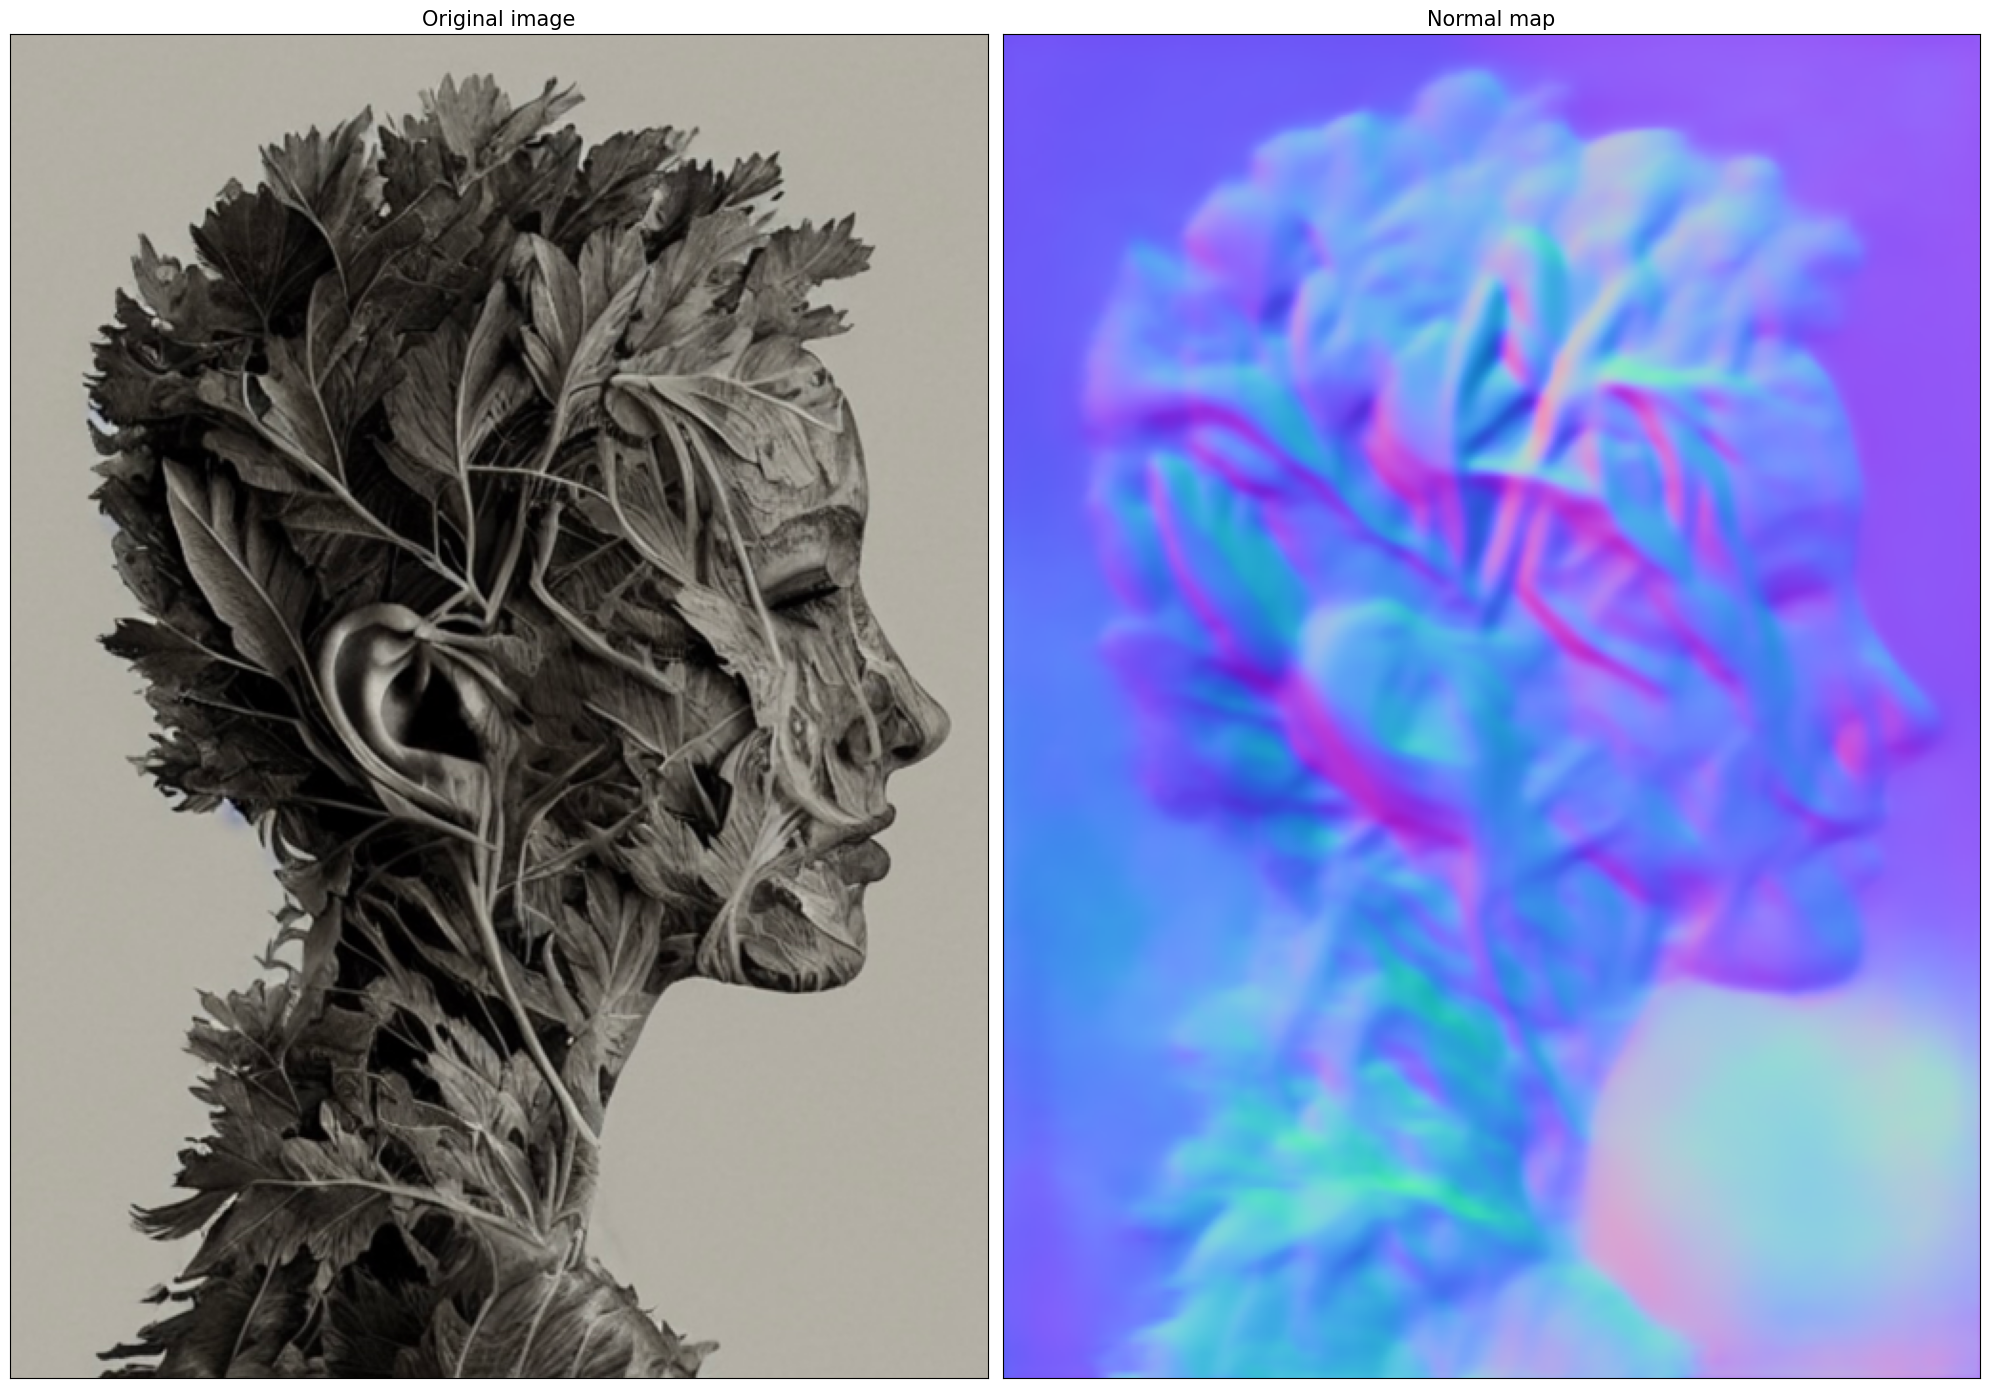

In [5]:
from controlnet_aux import NormalBaeDetector
from diffusers.utils import load_image
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

example_image_url = "https://huggingface.co/lllyasviel/control_v11p_sd15_normalbae/resolve/main/images/input.png"
urlretrieve(example_image_url, "example.png")

processor = NormalBaeDetector.from_pretrained("lllyasviel/Annotators")

image = load_image("example.png")
control_image = processor(image)


def visualize_results(orig_img:Image.Image, normal_img:Image.Image, result_img:Image.Image = None, save_fig:bool = False):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (Image.Image): original image
       normal_img (Image.Image): image with bwith surface normal information
       result_img (Image.Image, optional, default None): generated image
       safe_fig (bool, optional, default False): allow saving visualization result on disk
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "Original image"
    control_title = "Normal map"
    orig_img = orig_img.resize(normal_img.size if result_img is None else result_img.size)
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 20)
    num_images = 3 if result_img is not None else 2
    fig, axs = plt.subplots(num_images if is_horizontal else 1, 1 if is_horizontal else num_images, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(normal_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15) 
    if result_img is not None:
        list_axes[2].imshow(np.array(result_img))
        list_axes[2].set_title("Result", fontsize=15)
    
    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00 , hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    if save_fig:
        fig.savefig("result.png", bbox_inches='tight')
    return fig


fig = visualize_results(image, control_image)

## Convert models to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models conversion directly. We need to provide a model object, input data for model tracing to `ov.convert_model` function to obtain OpenVINO `ov.Model` object instance. Model can be saved on disk for next deployment using `ov.save_model` function.

The pipeline consists of five important parts:

* ControlNet for conditioning by image annotation.
* Text Encoder for creation condition to generate an image from a text prompt.
* Unet for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

### ControlNet conversion
[back to top ⬆️](#Table-of-contents:)

The ControlNet model accepts the same inputs like UNet in Stable Diffusion pipeline and additional condition sample - skeleton key points map predicted by pose estimator:

* `sample` - latent image sample from the previous step, generation process has not been started yet, so we will use random noise,
* `timestep` - current scheduler step,
* `encoder_hidden_state` - hidden state of text encoder,
* `controlnet_cond` - condition input annotation.

The output of the model is attention hidden states from down and middle blocks, which serves additional context for the UNet model.

In [6]:
import torch
import openvino as ov
from functools import partial

def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def flattenize_inputs(inputs):
    """
    Helper function for resolve nested input structure (e.g. lists or tuples of tensors)
    """
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64,
    torch.int32: ov.Type.i32,
    torch.int64: ov.Type.i64
}


def prepare_input_info(input_dict):
    """
    Helper function for preparing input info (shapes and data types) for conversion based on example inputs
    """
    flatten_inputs = flattenize_inputs(inputs.values())
    input_info = []
    for input_data in flatten_inputs:
        updated_shape = list(input_data.shape)
        if updated_shape:
            updated_shape[0] = -1
        if input_data.ndim == 4:
            updated_shape[2] = -1
            updated_shape[3] = -1

        input_info.append((dtype_mapping[input_data.dtype], updated_shape))
    return input_info


inputs = {
    "sample": torch.randn((1, 4, 64, 64)),
    "timestep": torch.tensor(1, dtype=torch.float32),
    "encoder_hidden_states": torch.randn((1,77,768)),
    "controlnet_cond": torch.randn((1,3,512,512))
}


# Prepare conditional inputs for U-Net
if not UNET_OV_PATH.exists():    
    controlnet.eval()
    with torch.no_grad():
        down_block_res_samples, mid_block_res_sample = controlnet(**inputs, return_dict=False)
    
if not CONTROLNET_OV_PATH.exists():
    input_info = prepare_input_info(inputs)
    with torch.no_grad():
        controlnet.forward = partial(controlnet.forward, return_dict=False)
        ov_model = ov.convert_model(controlnet, example_input=inputs, input=input_info)
        ov.save_model(ov_model, CONTROLNET_OV_PATH)
        del ov_model
        cleanup_torchscript_cache()
    print('ControlNet successfully converted to IR')
else:
    print(f"ControlNet will be loaded from {CONTROLNET_OV_PATH}")

del controlnet
gc.collect()

ControlNet will be loaded from model/controlnet-normalbae.xml


19

### U-Net
[back to top ⬆️](#Table-of-contents:)

The process of U-Net model conversion remains the same, like for original Stable Diffusion model, but with respect to the new inputs generated by ControlNet.

In [7]:
from typing import Tuple

class UnetWrapper(torch.nn.Module):
    def __init__(
        self, 
        unet, 
        sample_dtype=torch.float32, 
        timestep_dtype=torch.int64, 
        encoder_hidden_states=torch.float32, 
        down_block_additional_residuals=torch.float32, 
        mid_block_additional_residual=torch.float32
    ):
        super().__init__()
        self.unet = unet
        self.sample_dtype = sample_dtype
        self.timestep_dtype = timestep_dtype
        self.encoder_hidden_states_dtype = encoder_hidden_states
        self.down_block_additional_residuals_dtype = down_block_additional_residuals
        self.mid_block_additional_residual_dtype = mid_block_additional_residual

    def forward(
        self, 
        sample:torch.Tensor, 
        timestep:torch.Tensor, 
        encoder_hidden_states:torch.Tensor, 
        down_block_additional_residuals:Tuple[torch.Tensor],  
        mid_block_additional_residual:torch.Tensor
    ):
        sample.to(self.sample_dtype)
        timestep.to(self.timestep_dtype)
        encoder_hidden_states.to(self.encoder_hidden_states_dtype)
        down_block_additional_residuals = [res.to(self.down_block_additional_residuals_dtype) for res in down_block_additional_residuals]
        mid_block_additional_residual.to(self.mid_block_additional_residual_dtype)
        return self.unet(
            sample, 
            timestep, 
            encoder_hidden_states, 
            down_block_additional_residuals=down_block_additional_residuals, 
            mid_block_additional_residual=mid_block_additional_residual
        )



if not UNET_OV_PATH.exists():
    inputs.pop("controlnet_cond", None)
    inputs["down_block_additional_residuals"] = down_block_res_samples
    inputs["mid_block_additional_residual"] = mid_block_res_sample
    input_info = prepare_input_info(inputs)

    wrapped_unet = UnetWrapper(unet)
    wrapped_unet.eval()

    with torch.no_grad():
        ov_model = ov.convert_model(wrapped_unet, example_input=inputs)
        
    for (input_dtype, input_shape), input_tensor in zip(input_info, ov_model.inputs):
        input_tensor.get_node().set_partial_shape(ov.PartialShape(input_shape))
        input_tensor.get_node().set_element_type(input_dtype)
    ov_model.validate_nodes_and_infer_types()
    ov.save_model(ov_model, UNET_OV_PATH)
    del ov_model
    cleanup_torchscript_cache()
    del wrapped_unet
    del unet
    gc.collect()
    print('Unet successfully converted to IR')
else:
    del unet
    print(f"Unet will be loaded from {UNET_OV_PATH}")
gc.collect()

Unet will be loaded from model/unet_controlnet.xml


0

### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

The input of the text encoder is tensor `input_ids`, which contains indexes of tokens from text processed by the tokenizer and padded to the maximum length accepted by the model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - pooled output for whole model hidden states.

In [8]:
def convert_encoder(text_encoder:torch.nn.Module, ir_path:Path):
    """
    Convert Text Encoder model to OpenVINO IR. 
    Function accepts text encoder model, prepares example inputs for conversion, and convert it to OpenVINO Model
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model
        ir_path (Path): File for storing model
    Returns:
        None
    """
    if not ir_path.exists():
        input_ids = torch.ones((1, 77), dtype=torch.long)
        # switch model to inference mode
        text_encoder.eval()

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            ov_model = ov.convert_model(
                text_encoder,  # model instance
                example_input=input_ids,  # inputs for model tracing
                input=([1,77],)
            )
            ov.save_model(ov_model, ir_path)
            del ov_model
        cleanup_torchscript_cache()
        print('Text Encoder successfully converted to IR')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")
del text_encoder
gc.collect()

Text encoder will be loaded from model/text_encoder.xml


0

### VAE Decoder conversion
[back to top ⬆️](#Table-of-contents:)

The VAE model has two parts, an encoder, and a decoder. The encoder is used to convert the image into a low-dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. During inference, we will see that we **only need the VAE decoder**. You can find instructions on how to convert the encoder part in a stable diffusion [notebook](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb).

In [9]:
def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model to IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for convert, 
    Parameters: 
        vae (torch.nn.Module): VAE model
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)

    if not ir_path.exists():
        vae_decoder = VAEDecoderWrapper(vae)
        latents = torch.zeros((1, 4, 64, 64))

        vae_decoder.eval()
        with torch.no_grad():
            ov_model = ov.convert_model(vae_decoder, example_input=latents, input=[-1, 4, -1, -1])
            ov.save_model(ov_model, ir_path)
        del ov_model
        cleanup_torchscript_cache()
        print('VAE decoder successfully converted to IR')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae

VAE decoder will be loaded from model/vae_decoder.xml


## Prepare Inference pipeline
[back to top ⬆️](#Table-of-contents:)

We already deeply discussed how the ControlNet-guided pipeline works on example pose-controlled generation in [controlnet notebook](../235-controlnet-stable-diffusion). In our current example, the pipeline remains without changes.
Similarly to Diffusers `StableDiffusionControlNetPipeline`, we define our own `OVControlNetStableDiffusionPipeline` inference pipeline based on OpenVINO.

In [10]:
from diffusers import DiffusionPipeline
from transformers import CLIPTokenizer
from typing import Union, List, Optional, Tuple
import cv2


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: Image.Image, dst_height:int = 512, dst_width:int = 512):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (Image.Image): input image
      dst_width: destination image width
      dst_height: destination image height
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    res_width, res_height = scale_fit_to_window(dst_width, dst_height, src_width, src_height)
    image = np.array(image.resize((res_width, res_height), resample=Image.Resampling.LANCZOS))[None, :]
    pad_width = dst_width - res_width
    pad_height = dst_height - res_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = image.transpose(0, 3, 1, 2)
    return image, pad


def randn_tensor(
    shape: Union[Tuple, List],
    dtype: Optional[torch.dtype] = torch.float32,
):
    """
    Helper function for generation random values tensor with given shape and data type
    
    Parameters:
      shape (Union[Tuple, List]): shape for filling random values
      dtype (torch.dtype, *optiona*, torch.float32): data type for result
    Returns:
      latents (np.ndarray): tensor with random values with given data type and shape (usually represents noise in latent space)
    """
    latents = torch.randn(shape, dtype=dtype)
    return latents.numpy()


class OVControlNetStableDiffusionPipeline(DiffusionPipeline):
    """
    OpenVINO inference pipeline for Stable Diffusion with ControlNet guidence
    """
    def __init__(
        self,
        tokenizer: CLIPTokenizer,
        scheduler,
        core: ov.Core,
        controlnet: ov.Model,
        text_encoder: ov.Model,
        unet: ov.Model,
        vae_decoder: ov.Model,
        device:str = "AUTO"
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vae_scale_factor = 8
        self.scheduler = scheduler
        self.load_models(core, device, controlnet, text_encoder, unet, vae_decoder)

    def load_models(self, core: ov.Core, device: str, controlnet:ov.Model, text_encoder: ov.Model, unet: ov.Model, vae_decoder: ov.Model):
        """
        Function for loading models on device using OpenVINO
        
        Parameters:
          core (Core): OpenVINO runtime Core class instance
          device (str): inference device
          controlnet (Model): OpenVINO Model object represents ControlNet
          text_encoder (Model): OpenVINO Model object represents text encoder
          unet (Model): OpenVINO Model object represents UNet
          vae_decoder (Model): OpenVINO Model object represents vae decoder
        Returns
          None
        """
        self.text_encoder = core.compile_model(text_encoder, device)
        self.controlnet = core.compile_model(controlnet, device)
        self.unet = core.compile_model(unet, device)
        ov_config = {"INFERENCE_PRECISION_HINT": "f32"} if device != "CPU" else {}
        self.vae_decoder = core.compile_model(vae_decoder, device, ov_config)

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: Image.Image,
        num_inference_steps: int = 4,
        height:int = 512,
        width:int = 512,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: float = 0.5,
        controlnet_conditioning_scale: float = 1.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Parameters:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`Image.Image`):
                `Image`, or tensor representing an image batch which will be repainted according to `prompt`.
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            height (int, *optional*, defaults to 512): generated image height
            width (int, *optional*, defaults to 512): generated image width
            negative_prompt (`str` or `List[str]`):
                negative prompt or prompts for generation
            guidance_scale (`float`, *optional*, defaults to 0.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality. This pipeline requires a value of at least `1`.
            latents (`np.ndarray`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `Image.Image` or `np.array`.
        Returns:
            image ([List[Union[np.ndarray, Image.Image]]): generaited images
            
        """

        # 1. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        if guidance_scale < 1 and negative_prompt:
            guidance_scale += 1
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # 2. Encode input prompt
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)

        # 3. Preprocess image
        orig_width, orig_height = image.size
        image, pad = preprocess(image, height, width)
        if do_classifier_free_guidance:
            image = np.concatenate(([image] * 2))

        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            latents=latents,
        )

        # 6. Denoising loop
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand the latents if we are doing classifier free guidance.
                # The latents are expanded 3 times because for pix2pix the guidance\
                # is applied for both the text and the input image.
                latent_model_input = np.concatenate(
                    [latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                result = self.controlnet([latent_model_input, t, text_embeddings, image], share_inputs=True, share_outputs=True)
                down_and_mid_blok_samples = [sample * controlnet_conditioning_scale for _, sample in result.items()]

                # predict the noise residual
                noise_pred = self.unet([latent_model_input, t, text_embeddings, *down_and_mid_blok_samples], share_inputs=True, share_outputs=True)[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents)).prev_sample.numpy()
                progress_bar.update()

        # 7. Post-processing
        image = self.decode_latents(latents, pad)

        # 8. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            image = [img.resize((orig_width, orig_height), Image.Resampling.LANCZOS) for img in image]
        else:
            image = [cv2.resize(img, (orig_width, orig_width))
                     for img in image]

        return image

    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(text_input_ids, share_inputs=True, share_outputs=True)[0]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids, share_inputs=True, share_outputs=True)[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings

    def prepare_latents(self, batch_size:int, num_channels_latents:int, height:int, width:int, dtype:np.dtype = torch.float32, latents:np.ndarray = None):
        """
        Preparing noise to image generation. If initial latents are not provided, they will be generated randomly, 
        then prepared latents scaled by the standard deviation required by the scheduler
        
        Parameters:
           batch_size (int): input batch size
           num_channels_latents (int): number of channels for noise generation
           height (int): image height
           width (int): image width
           dtype (np.dtype, *optional*, np.float32): dtype for latents generation
           latents (np.ndarray, *optional*, None): initial latent noise tensor, if not provided will be generated
        Returns:
           latents (np.ndarray): scaled initial noise for diffusion
        """
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if latents is None:
            latents = randn_tensor(shape, dtype=dtype)
        else:
            latents = latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def decode_latents(self, latents:np.array, pad:Tuple[int]):
        """
        Decode predicted image from latent space using VAE Decoder and unpad image result
        
        Parameters:
           latents (np.ndarray): image encoded in diffusion latent space
           pad (Tuple[int]): each side padding sizes obtained on preprocessing step
        Returns:
           image: decoded by VAE decoder image
        """
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[0]
        (_, end_h), (_, end_w) = pad[1:3]
        h, w = image.shape[2:]
        unpad_h = h - end_h
        unpad_w = w - end_w
        image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        return image

### Prepare tokenizer and LCMScheduler
[back to top ⬆️](#Table-of-contents:)

Tokenizer and scheduler are also important parts of the diffusion pipeline. The tokenizer is responsible for preprocessing user-provided prompts into token ids that then used by Text Encoder.

The scheduler takes a model’s output (the sample which the diffusion process is iterating on) and a timestep to return a denoised sample. The timestep is important because it dictates where in the diffusion process the step is; data is generated by iterating forward n timesteps and inference occurs by propagating backward through the timesteps. There are many [schedulers](https://huggingface.co/docs/diffusers/api/schedulers/overview) implemented inside the diffusers library, LCM pipeline required changing the original pipeline scheduler with [LCMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/lcm).

In [11]:
from diffusers import LCMScheduler
from transformers import AutoTokenizer

if not TOKENIZER_PATH.exists():
    tokenizer = AutoTokenizer.from_pretrained(stable_diffusion_id, subfolder="tokenizer")
    tokenizer.save_pretrained(TOKENIZER_PATH)
else:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
if not SCHEDULER_PATH.exists():
    scheduler = LCMScheduler.from_pretrained(stable_diffusion_id, subfolder="scheduler")
    scheduler.save_pretrained(SCHEDULER_PATH)
else:
    scheduler = LCMScheduler.from_config(SCHEDULER_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ea/work/openvino_notebooks/test_env/lib/python3.8/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_lcm.LCMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


### Select inference device for Stable Diffusion pipeline
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [12]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [13]:
ov_pipe = OVControlNetStableDiffusionPipeline(tokenizer, scheduler, core, CONTROLNET_OV_PATH, TEXT_ENCODER_OV_PATH, UNET_OV_PATH, VAE_DECODER_OV_PATH, device=device.value)

## Running Text-to-Image Generation with ControlNet Conditioning and OpenVINO
[back to top ⬆️](#Table-of-contents:)

Now, we are ready to start generation. For improving the generation process, we also introduce an opportunity to provide a `negative prompt`. Technically, positive prompt steers the diffusion toward the images associated with it, while negative prompt steers the diffusion away from it. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/). We can keep this field empty if we want to generate image without negative prompting.

[Classifier-free guidance (CFG)](https://arxiv.org/abs/2207.12598) or guidance scale is a parameter that controls how much the image generation process follows the text prompt. The higher the value, the more the image sticks to a given text input. But this does not mean that the value should always be set to maximum, as more guidance means less diversity and quality. According to experiments, the optimal value of guidance for LCM models is in range between 0 and 2. 
> Please note, that negative prompt is applicable only when guidance scale > 1.

Let's see model in action

  0%|          | 0/4 [00:00<?, ?it/s]

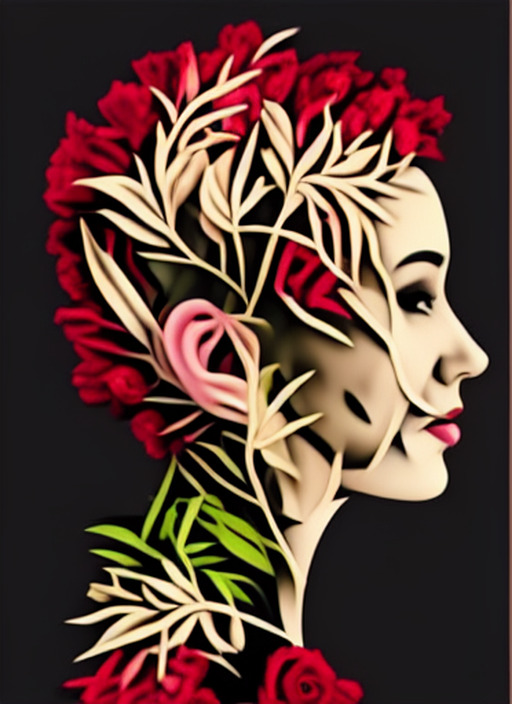

In [14]:
prompt = "A head full of roses"
torch.manual_seed(4257)

result = ov_pipe(prompt, control_image, 4)
result[0]

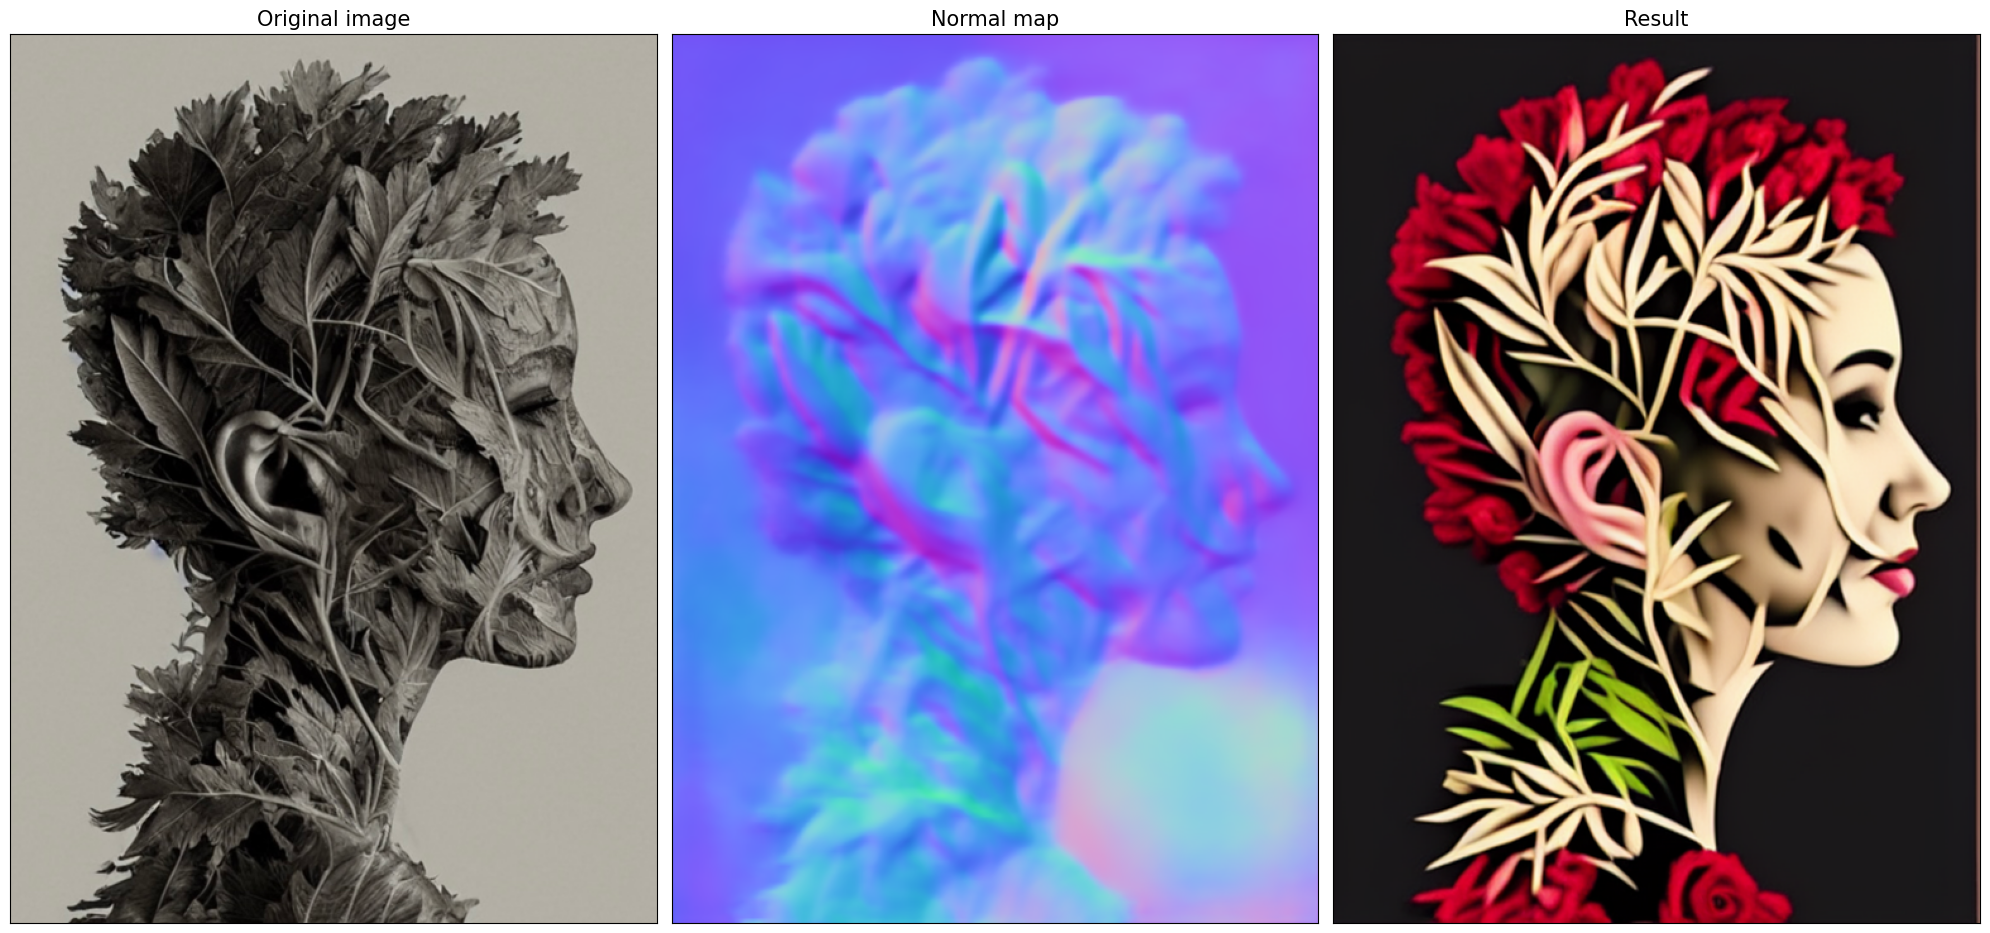

In [15]:
fig = visualize_results(image, control_image, result[0])

## Interactive Demo
[back to top ⬆️](#Table-of-contents:)

Now, you can test model on own images. Please, provide image into `Input Image` window and prompts for generation and click `Run` button. To achieve the best results, you also can select additional options for generation: `Guidance scale`, `Seed` and `Steps`.

In [ ]:
import gradio as gr
MAX_SEED = np.iinfo(np.int32).max

gr.close_all()
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            inp_img = gr.Image(label="Input image")
        with gr.Column(visible=True) as step1:
            out_normal = gr.Image(label="Normal Map", type='pil', interactive=False)
            btn = gr.Button()
            inp_prompt = gr.Textbox(label="Prompt")
            inp_neg_prompt = gr.Textbox(
                "",
                label="Negative prompt",
            )
            with gr.Accordion("Advanced options", open=False):
                guidance_scale = gr.Slider(
                    label="Guidance scale",
                    minimum=0.1,
                    maximum=2,
                    step=0.1,
                    value=0.5,
                )
                inp_seed = gr.Slider(label="Seed", value=42, maximum=MAX_SEED)
                inp_steps = gr.Slider(label="Steps", value=4, minimum=1, maximum=50)
        with gr.Column(visible=True) as step2:
            out_result = gr.Image(label="Result")
    examples = gr.Examples([["example.png", "a head full of roses"]], [inp_img, inp_prompt])

    def extract_normal_map(img):
        if img is None:
            raise gr.Error("Please upload the image or use one from the examples list")
        return processor(img)

    def generate(img, prompt, negative_prompt, seed, num_steps, guidance_scale, progress=gr.Progress(track_tqdm=True)):
        torch.manual_seed(seed)
        control_img = extract_normal_map(img)
        
        result = ov_pipe(prompt, control_img, num_steps, guidance_scale=guidance_scale, negative_prompt=negative_prompt)[0]
        return control_img, result

    btn.click(generate, [inp_img, inp_prompt, inp_neg_prompt, inp_seed, inp_steps, guidance_scale], [out_normal, out_result])


try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True, height=800)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/